## Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN,LSTM,GRU, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
from shapely.geometry import Point
import folium
from sklearn.metrics import accuracy_score
import random
from shapely.geometry import LineString, box

In [ ]:
drive.mount('/content/drive')
# %cd '/content/drive/MyDrive/T5/Capstone_Project_T5'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load Data

In [ ]:
gdf = gpd.read_file('/content/drive/MyDrive/T5/Capstone_Project_T5/data 6 month/merged_6month.gpkg')
gdf.set_index('time_series_left', inplace=True)
gdf.index.name = 'time_series'
gdf.sort_index(inplace=True)

# Exploratory Data Analysis (EDA)

In [ ]:
# if gdf['time_series_left'].equals(gdf['time_series_right']):
#     print("OK")

In [ ]:
if gdf['street_name_left'].equals(gdf['street_name_right']):
    print("OK")

In [ ]:
gdf.head(5)

,accident_id,street_name_left,number_of_cars_involved,accident_reason,number_of_injured,traffic_id,time_series_right,street_name_right,weather,number_of_cars,average_car_speed,traffic_status,day_name,date,point_geometry_wkt,geometry
time_series,,,,,,,,,,,,,,,,
2023-01-01 06:00:00,0,طريق خريص,3,Road Conditions,0,177,2023-01-01 06:00:00,طريق خريص,Clear,1464,101.28,Light,Sunday,None,POINT (46.8123571 24.7456475),"LINESTRING (46.81213 24.7455, 46.81236 24.74565)"
2023-01-01 11:00:00,1,خريص,3,Speeding,0,2329,2023-01-01 11:00:00,خريص,Cloudy,771,37.18,Heavy,Sunday,None,POINT (46.794121 24.7343353),"LINESTRING (46.79363 24.73404, 46.79412 24.73434)"
2023-01-01 14:00:00,2,خريص,2,Road Conditions,0,3732,2023-01-01 14:00:00,خريص,Rainy,360,31.73,Heavy,Sunday,None,POINT (46.7826574 24.7277724),"LINESTRING (46.78266 24.72777, 46.7817 24.72718)"
2023-01-01 16:00:00,3,خريص,2,Road Conditions,0,4768,2023-01-01 16:00:00,خريص,Clear,955,55.54,Moderate,Sunday,None,POINT (46.8631253 24.7938616),"LINESTRING (46.86313 24.79386, 46.86064 24.79053)"
2023-01-02 06:00:00,6,طريق خريص,2,Road Conditions,3,6198,2023-01-02 06:00:00,طريق خريص,Foggy,1145,57.58,Moderate,Monday,None,POINT (46.9924938 24.9288979),"LINESTRING (46.97912 24.90795, 46.98097 24.909..."


In [ ]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
DatetimeIndex: 1038 entries, 2023-01-01 06:00:00 to 2023-06-30 23:00:00
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   accident_id              1038 non-null   int64         
 1   street_name_left         1038 non-null   object        
 2   number_of_cars_involved  1038 non-null   int64         
 3   accident_reason          1038 non-null   object        
 4   number_of_injured        1038 non-null   int64         
 5   traffic_id               1038 non-null   int64         
 6   time_series_right        1038 non-null   datetime64[ms]
 7   street_name_right        1038 non-null   object        
 8   weather                  1038 non-null   object        
 9   number_of_cars           1038 non-null   int64         
 10  average_car_speed        1038 non-null   float64       
 11  traffic_status           1038 non-null   object    

In [ ]:
gdf.describe()

,accident_id,number_of_cars_involved,number_of_injured,traffic_id,time_series_right,number_of_cars,average_car_speed
count,1038.000000,1038.000000,1038.000000,1038.000000,1038,1038.000000,1038.000000
mean,518.500000,2.111753,0.586705,470484.537572,2023-03-31 23:54:54.797000,777.399807,44.224297
min,0.000000,1.000000,0.000000,177.000000,2023-01-01 06:00:00,200.000000,5.060000
25%,259.250000,1.000000,0.000000,217494.250000,2023-02-11 20:15:00,520.250000,29.062500
50%,518.500000,2.000000,0.000000,479888.500000,2023-04-02 23:30:00,816.000000,37.970000
75%,777.750000,2.000000,0.000000,702467.250000,2023-05-15 13:15:00,1018.000000,55.927500
max,1037.000000,10.000000,5.000000,946019.000000,2023-06-30 23:00:00,1495.000000,119.780000
std,299.789093,1.275478,1.340597,274097.163084,NaN,312.807875,25.307600


In [ ]:
gdf.isnull().sum()

,0
accident_id,0
street_name_left,0
number_of_cars_involved,0
accident_reason,0
number_of_injured,0
traffic_id,0
time_series_right,0
street_name_right,0
weather,0
number_of_cars,0


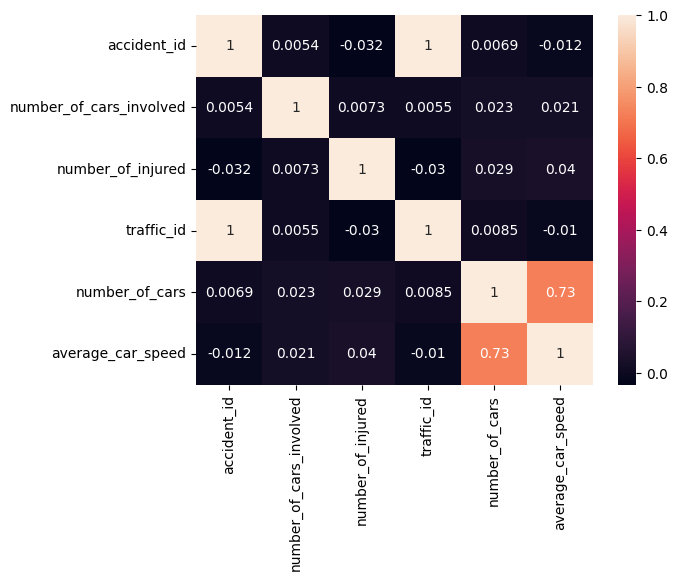

In [ ]:
num_columns = gdf.select_dtypes(include=['number','float64'])
sns.heatmap(num_columns.corr(),annot=True)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

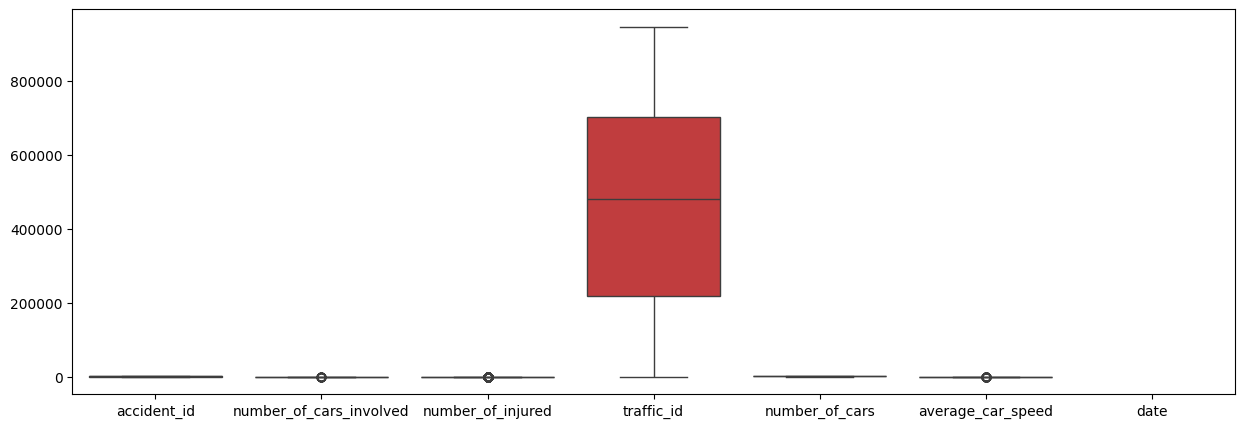

In [ ]:
plt.figure(figsize=(15, 5))
sns.boxplot(gdf)
plt.show()

##Plot Data

<Axes: >

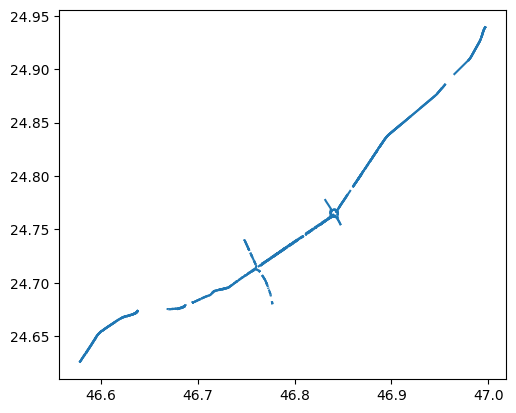

In [ ]:
gdf.plot()

# Data Preprocessing

##Update Columns for 'Average Car Speed,' 'Number of Cars,' and 'Traffic Status' to Reflect Real Bottlenecks More Accurately and Logically

In [ ]:
# Define bounding boxes for Bottlenecks
bbox1 = box(46.780923, 24.727429, 46.807406, 24.742193)
bbox2 = box(46.672496, 24.674584, 46.683905, 24.677683)
bbox3 = box(46.692658, 24.682768, 46.756313, 24.708039)

def is_within_bounding_box(line, bbox):
    return bbox.intersects(line)

# Print the updated DataFrame shape and a few rows to check
print(f"Before Updated columns: {gdf.shape}")
print(gdf[['average_car_speed', 'number_of_cars', 'traffic_status']].head(10))

# Initialize new columns with default values
gdf['traffic_status'] = ''
gdf['number_of_cars'] = 0
gdf['average_car_speed'] = 0.0

# Iterate over the rows of the GeoDataFrame
for index, row in gdf.iterrows():
    datetime_instance = row['time_series_right'].to_pydatetime()
    line_geometry = row['geometry']

    # Check if the line geometry is within one of the bounding boxes
    if is_within_bounding_box(line_geometry, bbox1) or is_within_bounding_box(line_geometry, bbox2):
        traffic_status = 'Moderate'
        num_cars = random.randint(20, 50)
        avg_speed = round(random.uniform(30, 50), 2)
    elif is_within_bounding_box(line_geometry, bbox3):
        traffic_status = 'Heavy'
        num_cars = random.randint(50, 150)
        avg_speed = round(random.uniform(40, 100), 2)
    else:
        if 6 < datetime_instance.hour < 19:
            num_cars = random.randint(30, 120)
            avg_speed = round(random.uniform(5, 80), 2)
        else:
            num_cars = random.randint(10, 50)
            avg_speed = round(random.uniform(40, 120), 2)
        traffic_status = 'Heavy' if num_cars >= 50 and avg_speed <= 30 else 'Moderate' if num_cars < 30 else 'Light'

    # Assign values directly to the GeoDataFrame columns for the current row
    gdf.loc[index, 'traffic_status'] = traffic_status
    gdf.loc[index, 'number_of_cars'] = num_cars
    gdf.loc[index, 'average_car_speed'] = avg_speed

def update_traffic_status(row):
    if row['average_car_speed'] > 90:
        return 'Light'
    elif 70 < row['average_car_speed'] <= 90:
        return 'Moderate'
    elif 40 < row['average_car_speed'] <= 70:
        return 'Moderate'
    elif row['average_car_speed'] <= 40:
        return 'Heavy'

# Apply the function to update traffic_status in the merged DataFrame
gdf['traffic_status'] = gdf.apply(update_traffic_status, axis=1)

# Print the updated DataFrame shape and a few rows to check
print(f"\n\nAfter Updated columns: {gdf.shape}")
print(gdf[['average_car_speed', 'number_of_cars', 'traffic_status']].head(10))

Before Updated columns: (1038, 16)
                     average_car_speed  number_of_cars traffic_status
time_series                                                          
2023-01-01 06:00:00             101.28            1464          Light
2023-01-01 11:00:00              37.18             771          Heavy
2023-01-01 14:00:00              31.73             360          Heavy
2023-01-01 16:00:00              55.54             955       Moderate
2023-01-02 06:00:00              57.58            1145       Moderate
2023-01-02 08:00:00               5.20             640          Heavy
2023-01-02 14:00:00              27.17             854          Heavy
2023-01-02 18:00:00              32.44             731          Heavy
2023-01-02 18:00:00              18.61             266          Heavy
2023-01-03 06:00:00             107.16            1155          Light


After Updated columns: (1038, 16)
                     average_car_speed  number_of_cars traffic_status
time_series        

##Save Data

In [ ]:
# save gdf
gdf.to_csv('merged_6month_update.csv')
# Use to_file to save as GeoPackage
gdf.to_file('merged_6month_update.gpkg', driver='GPKG')
gdf.to_file('merged_6month_update.geojson', driver='GeoJSON')